In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [3]:
dataset = pd.read_csv("facial_expressions/data/legend.csv")
dataset = dataset.drop(["user.id"], axis=1)
dataset['emotion'] = dataset['emotion'].str.lower()

In [4]:
class_mapping = dict( zip( dataset["emotion"].astype('category').cat.codes, dataset["emotion"]))
dataset["emotion_class"] = dataset["emotion"].astype('category').cat.codes

In [5]:
for i in sorted(class_mapping.keys()):
  print(i, class_mapping[i])

0 anger
1 contempt
2 disgust
3 fear
4 happiness
5 neutral
6 sadness
7 surprise


In [6]:
dataset.head(10)

,image,emotion,emotion_class
0,facial-expressions_2868588k.jpg,anger,0
1,facial-expressions_2868585k.jpg,surprise,7
2,facial-expressions_2868584k.jpg,disgust,2
3,facial-expressions_2868582k.jpg,fear,3
4,Aaron_Eckhart_0001.jpg,neutral,5
5,Aaron_Guiel_0001.jpg,happiness,4
6,Aaron_Patterson_0001.jpg,neutral,5
7,Aaron_Peirsol_0001.jpg,happiness,4
8,Aaron_Peirsol_0002.jpg,happiness,4
9,Aaron_Peirsol_0003.jpg,happiness,4


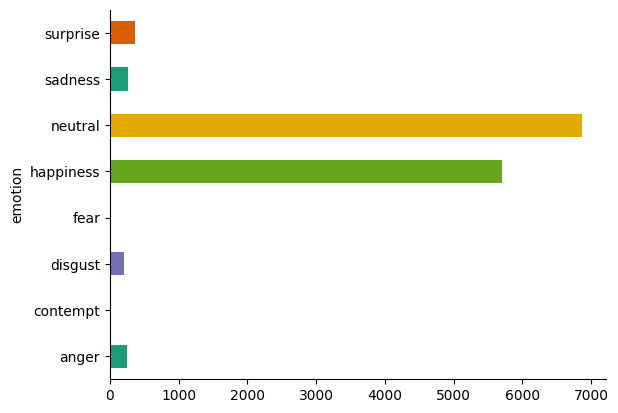

In [7]:
dataset.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
xtrain, xval, ytrain, yval = train_test_split(dataset["image"], dataset["emotion_class"], test_size=0.2, random_state=77, stratify=dataset["emotion_class"])

In [9]:
weights = compute_class_weight(class_weight="balanced", classes=np.unique(dataset["emotion_class"]), y=dataset["emotion_class"])

In [10]:
class EmotionTrainDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.resize(cv2.imread("facial_expressions/images/" + self.images.iloc[idx]), (128,128)) / 255.
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.labels.iloc[idx].astype(np.float32)
        return image, label

In [97]:
traindataset = EmotionTrainDataset(xtrain, ytrain)
valdataset = EmotionTrainDataset(xval, yval)
traindataloader = DataLoader(traindataset, batch_size=32, shuffle=True)
valdataloader = DataLoader(valdataset, batch_size=32, shuffle=True)

In [98]:
class  CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.relu4 = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 8)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            output = self.forward(x)
        return output.argmax(dim=1)

In [99]:
def train(model, optimizer, criterion, dataloader, device, train=True):
    model.train()
    running_loss = 0.0
    loss_list = []
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        if train:
          loss.backward()
          optimizer.step()
        running_loss += loss.item()

    return running_loss / len(dataloader)

In [100]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred += predicted.cpu().numpy().tolist()
    return correct / total, y_pred

In [120]:
CNN = CNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN.to(device)
loss = torch.nn.NLLLoss(weight=torch.Tensor(weights).to(device))
optimizer = torch.optim.Adam(CNN.parameters(), lr=0.0001)
epochs = 30
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(CNN, optimizer, loss, traindataloader, device)
    val_loss = train(CNN, optimizer, loss, valdataloader, device, train=False)
    # train_acc = evaluate(CNN, traindataloader, device)
    # val_acc = evaluate(CNN, valdataloader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # train_accuracies.append(train_acc)
    # val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/30, Loss: 1.8375, Val Loss: 1.8392
Epoch 2/30, Loss: 1.6776, Val Loss: 1.7050
Epoch 3/30, Loss: 1.5405, Val Loss: 1.6623
Epoch 4/30, Loss: 1.4266, Val Loss: 1.5867
Epoch 5/30, Loss: 1.3638, Val Loss: 1.5097
Epoch 6/30, Loss: 1.2627, Val Loss: 1.4756
Epoch 7/30, Loss: 1.1648, Val Loss: 1.4545
Epoch 8/30, Loss: 1.0866, Val Loss: 1.5394
Epoch 9/30, Loss: 1.0021, Val Loss: 1.4624
Epoch 10/30, Loss: 0.9498, Val Loss: 1.5841
Epoch 11/30, Loss: 0.8771, Val Loss: 1.4416
Epoch 12/30, Loss: 0.8073, Val Loss: 1.6038
Epoch 13/30, Loss: 0.7338, Val Loss: 1.5471
Epoch 14/30, Loss: 0.6777, Val Loss: 1.6656
Epoch 15/30, Loss: 0.6146, Val Loss: 1.6075
Epoch 16/30, Loss: 0.5431, Val Loss: 1.9353
Epoch 17/30, Loss: 0.5167, Val Loss: 1.8339
Epoch 18/30, Loss: 0.4617, Val Loss: 1.7368
Epoch 19/30, Loss: 0.4216, Val Loss: 1.9210
Epoch 20/30, Loss: 0.3975, Val Loss: 2.1310
Epoch 21/30, Loss: 0.3544, Val Loss: 2.0591
Epoch 22/30, Loss: 0.3229, Val Loss: 2.1890
Epoch 23/30, Loss: 0.2836, Val Loss: 2.55

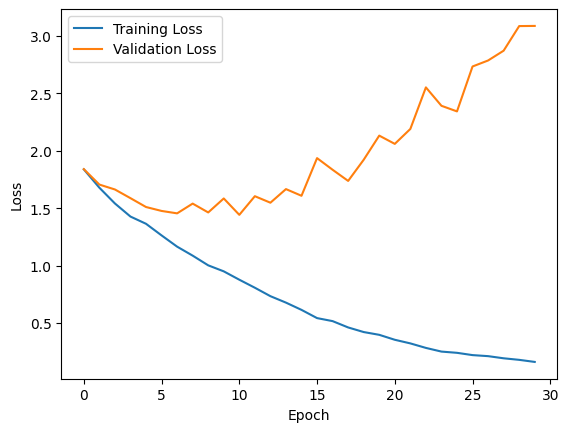

In [121]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [122]:
acc, _ = evaluate(CNN, traindataloader, device)
acc

0.9204711468224982

In [123]:
acc, y_pred = evaluate(CNN, valdataloader, device)
acc

0.8035062089116143

In [124]:
y_pred = []
yval_loader = []
for inputs, labels in valdataloader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = CNN(inputs)
  predicted = outputs.argmax(dim=1)
  y_pred.extend(predicted.cpu().numpy())
  yval_loader.extend(labels.cpu().numpy())

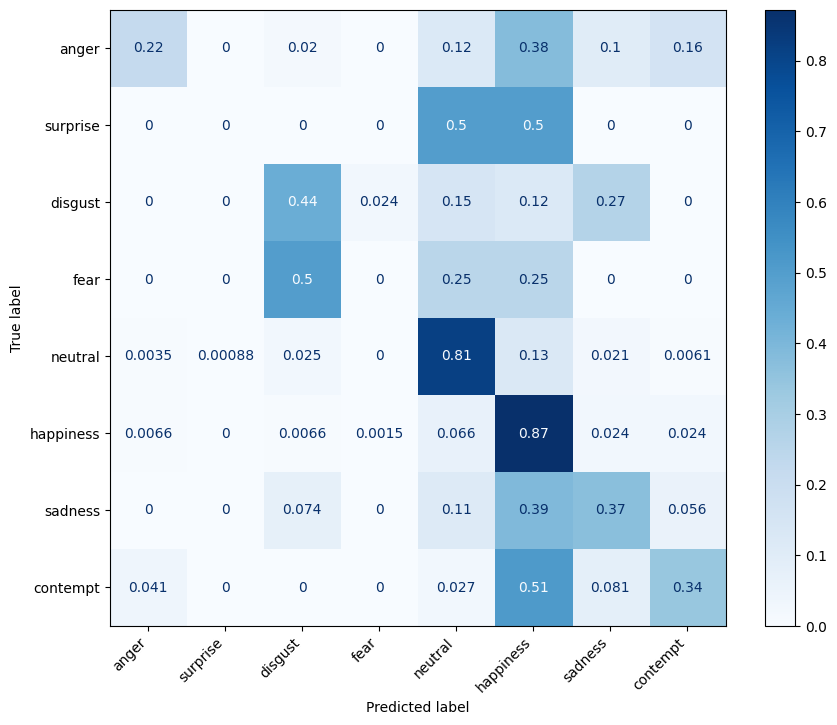

In [126]:
cm = confusion_matrix(yval_loader, y_pred, labels=[i for i in range(8)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(class_mapping.values()))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

In [127]:
print(classification_report(yval_loader, y_pred))

              precision    recall  f1-score   support

         0.0       0.41      0.22      0.29        50
         1.0       0.00      0.00      0.00         2
         2.0       0.29      0.44      0.35        41
         3.0       0.00      0.00      0.00         4
         4.0       0.89      0.81      0.85      1139
         5.0       0.84      0.87      0.85      1374
         6.0       0.20      0.37      0.26        54
         7.0       0.33      0.34      0.33        74

    accuracy                           0.80      2738
   macro avg       0.37      0.38      0.37      2738
weighted avg       0.82      0.80      0.81      2738



In [128]:
from sklearn.metrics import f1_score
f1_score(yval_loader, y_pred, average="weighted")

0.8078589622773965